In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi



from qutip import *
from qutip.control import *
from qutip.qip.operations import rx
from qutip.qip.operations import ry
from qutip.qip.operations import rz

from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

# Finding Pulse Sequence

## Defining 3x3 rotation gates
## Setting time bounds
## setting desired U value

In [12]:

#def rx3(phi, N=None, target=0):
    
   # rotationx= Qobj([[1,0,0],
                    #[0,np.cos(phi), -1*np.sin(phi )],
                    # [0, np.sin(phi ), np.cos(phi )]])
    
    #return rotationx



def rz3(phi, N=None, target=0):
    
    rotationx= Qobj([[np.exp(-1j*(phi/2)),0,0],
                            [0,0,0],
                            [0,0,-np.exp(1j*(phi/2))]])
    
    return rotationx


T = 1
times = np.linspace(0, T, 100)

#theta, phi = np.random.rand(2)
theta, phi = [pi/2, pi/4]

# target unitary transformation (random single qubit rotation)
#U = rz(phi) * rx(theta) 
#U

#U= rz3(phi) #* rx3(theta) 
U=1 * rz3(np.pi)
U

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j]]

## Defining 3x3 pauli spin matrices 
## Definiting number of iterations
## Defining H_ops

In [13]:
sigmaX3=Qobj([[0,1/np.sqrt(2),0],
        [1/np.sqrt(2),0,1/np.sqrt(2)],
        [0,1/np.sqrt(2),0]])

sigmaY3=Qobj([[0,-1j*1/np.sqrt(2),0],
        [1j*1/np.sqrt(2),0,-1j*1/np.sqrt(2)],
        [0,1j*1/np.sqrt(2),0]])


sigmaZ3=Qobj([[1/np.sqrt(2),0,0],
        [0,0,0],
        [0,0,-1/np.sqrt(2)]])


#print (sigmaZ3)


R = 150
H_ops = [sigmaX3, sigmaY3, sigmaZ3]

H_labels = [r'$u_{x}$',
            r'$u_{y}$',
            r'$u_{z}$',
            ]




In [38]:
#defining hamiltonian for NV center
#ASK MAX ABOUT UNITS!!!!!!!!!!!!!!!!!

#converted everything to Hz


#defining constants in hamiltonian
h= 6.582119 * 1e-16 #eV * sec ???????????? what h bar to use
D= 2.87 * 1e9 #given in GHz converted to Hz
E= 5.2 * 1e6 #given in MHz converted to Hz 
delta_parallel= 0.17 #Hz/(V*m^-1)
delta_perpendicular= 1e-3 #Hz/(V*m^-1)
epsilonX= 1.31 * 1e6 #given in MHz converted to Hz
epsilonY= 1.31 * 1e6 #given in MHz converted to Hz
epsilonZ= 1.31 * 1e6 #given in MHz converted to Hz
gamma_nv = 2 * np.pi * 28 * 1e6 #given in MHz/mt converted to Hz/mT


#squaring matrices
sigmaX3squared=sigmaX3*sigmaX3
sigmaY3squared=sigmaY3*sigmaY3
sigmaZ3squared=sigmaZ3*sigmaZ3




H1 = h * D * (sigmaZ3squared-(2/3)) + h * E * (sigmaX3squared-sigmaY3squared)
#H2= 0
#H3= h * delta_parallel * epsilonZ * (sigmaZ3squared-(2/3)) - (h * delta_perpendicular) \
       # * ((epsilonX * np.matmul(sigmaX3,sigmaY3) + np.matmul(sigmaY3,sigmaX3)) + (epsilonY (sigmaX3squared - sigmaY3squared))) 

H3= h * delta_parallel * epsilonZ * (sigmaZ3squared-(2/3)) - ((h * delta_perpendicular) \
        * ((epsilonX * ((sigmaX3*sigmaY3) + (sigmaY3*sigmaX3))) + (epsilonY * (sigmaX3squared - sigmaY3squared))))

H2 = -h * gamma_nv * np.dot(Svector,Bvector)


#H0= H1+H2+H3
H0 = H2




In [59]:
#making S a vector


#making my Bs,setting the B-field to be along the NV axis
Bx = 1 #mT
By = 1 #mT
Bz = 1 #mT

#making my B and S  vectors
Bvector = Qobj(np.array([Bx,By,Bz]))

Svector = ([sigmaX3,sigmaY3,sigmaZ3])
dot = Svector*Bvector
dot
#just do it in a for loop manually, this does not actually look like what a dot product should look like 

array([Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
       Qobj data =
       [[0.70710678]
        [1.41421356]
        [0.70710678]]                                               ,
       Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
       Qobj data =
       [[0.-0.70710678j]
        [0.+0.j        ]
        [0.+0.70710678j]]                                           ,
       Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
       Qobj data =
       [[ 0.70710678]
        [ 0.        ]
        [-0.70710678]]                                              ],
      dtype=object)

In [34]:
H0

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[-2.44306317e-11  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -9.77225268e-11  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.44306317e-11]]

In [30]:

u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10) / 10, u0[idx, :], mode='same') for idx in range(len(H_ops))]

print(U,H0,H_ops)
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2 * pi / T, phase_sensitive=False,
                          #progress_bar=TextProgressBar())



plot_grape_control_fields(times, result.u[:, :, :] / (2 * pi), H_labels, uniform_axes=True);
plt.show()

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j]] Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[-3.14844692e-07  0.00000000e+00  3.42270188e-09]
 [ 0.00000000e+00 -1.25937877e-06  0.00000000e+00]
 [ 3.42270188e-09  0.00000000e+00 -3.14844692e-07]] [Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.70710678]
 [0.         0.70710678 0.        ]], Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.+0.j         0.-0.70710678j 0.+0.j        ]
 [0.+0.70710678j 0.+0.j         0.-0.70710678j]
 [0.+0.j         0.+0.70710678j 0.+0.j        ]], Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.70710678  0.          0.        ]
 [ 0.          0.         

# Calcuate overlap (is this fidelity?)

In [21]:
U

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j]]

In [22]:
result.U_f

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
Qobj data =
[[ 9.99999964e-01-1.56109715e-04j -1.63145523e-04-1.47818721e-04j
   2.34900205e-09+2.41073198e-08j]
 [ 1.63122455e-04-1.47926108e-04j  9.99999870e-01-8.88726601e-12j
  -1.63122425e-04-1.47926117e-04j]
 [ 2.33095077e-09+5.77523207e-08j  1.63145530e-04-1.47900625e-04j
   9.99999964e-01+1.56109737e-04j]]

In [23]:
# target / result overlap
_overlap(U, result.U_f).real, abs(_overlap(U, result.U_f))**2

(-7.392607937843168e-12, 0.444444412053894)

# How is the overlap different?


In [9]:
print (times[-1])

1.0


In [10]:
c_ops = []

In [11]:
U_f_numerical = propagator(result.H_t, times, c_ops, args={})

In [12]:
U_f_numerical

array([Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
       Qobj data =
       [[1. 0. 0.]
        [0. 1. 0.]
        [0. 0. 1.]]                                                                 ,
       Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
       Qobj data =
       [[ 9.99933250e-01+1.15529461e-02j  1.35391947e-04-8.35187007e-05j
          5.52236701e-09-1.14051623e-08j]
        [-1.34417230e-04-8.50756997e-05j  9.99999975e-01+1.27219845e-08j
          1.34417231e-04-8.50756975e-05j]
        [ 5.52236703e-09+1.13360185e-08j -1.35391946e-04-8.35187028e-05j
          9.99933250e-01-1.15529397e-02j]]                                           ,
       Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = False
       Qobj data =
       [[ 9.99733322e-01+2.30908823e-02j  2.55929935e-04-1.72469199e-04j
          1.68126556e-08-4.46057759e-08j]
        [-2.51877830e-04-1.78330159e-04j  9.99999905e-01+

In [13]:
_overlap(U, U_f_numerical[-1]).real, abs(_overlap(U, U_f_numerical[-1]))**2

(-2.0978220764226543e-07, 0.44387027435703924)

# Bloch Sphere

In [14]:
psi0 = basis(3, 0)
e_ops = [sigmaX3, sigmaY3, sigmaZ3]

In [15]:
print (result.H_t)

[Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[-3.14869123e-07  0.00000000e+00  3.42270188e-09]
 [ 0.00000000e+00 -1.25947649e-06  0.00000000e+00]
 [ 3.42270188e-09  0.00000000e+00 -3.14869123e-07]], [Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.70710678]
 [0.         0.70710678 0.        ]], array([ 0.01140903,  0.01220828,  0.01359497,  0.0165665 ,  0.01789159,
        0.01789789,  0.01821463,  0.0184888 ,  0.01823797,  0.01671073,
        0.01518483,  0.01550913,  0.01619181,  0.01342381,  0.01194694,
        0.01443929,  0.01225331,  0.01080089,  0.00886052,  0.00858348,
        0.00962301,  0.01011529,  0.00856329,  0.00942183,  0.01155369,
        0.00910221,  0.01153224,  0.0119    ,  0.01258888,  0.01249032,
        0.01246834,  0.0102627 ,  0.01126168,  0.00955399,  0.00821437,
        0.00747004,  0.00456416,  0.00263532,  0.

In [16]:
print (psi0)

Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]]


In [17]:
print (times)

[0.         0.01010101 0.02020202 0.03030303 0.04040404 0.05050505
 0.06060606 0.07070707 0.08080808 0.09090909 0.1010101  0.11111111
 0.12121212 0.13131313 0.14141414 0.15151515 0.16161616 0.17171717
 0.18181818 0.19191919 0.2020202  0.21212121 0.22222222 0.23232323
 0.24242424 0.25252525 0.26262626 0.27272727 0.28282828 0.29292929
 0.3030303  0.31313131 0.32323232 0.33333333 0.34343434 0.35353535
 0.36363636 0.37373737 0.38383838 0.39393939 0.4040404  0.41414141
 0.42424242 0.43434343 0.44444444 0.45454545 0.46464646 0.47474747
 0.48484848 0.49494949 0.50505051 0.51515152 0.52525253 0.53535354
 0.54545455 0.55555556 0.56565657 0.57575758 0.58585859 0.5959596
 0.60606061 0.61616162 0.62626263 0.63636364 0.64646465 0.65656566
 0.66666667 0.67676768 0.68686869 0.6969697  0.70707071 0.71717172
 0.72727273 0.73737374 0.74747475 0.75757576 0.76767677 0.77777778
 0.78787879 0.7979798  0.80808081 0.81818182 0.82828283 0.83838384
 0.84848485 0.85858586 0.86868687 0.87878788 0.88888889 0.89898

In [18]:
print (c_ops)

[]


In [19]:
print (e_ops)

[Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.         0.70710678 0.        ]
 [0.70710678 0.         0.70710678]
 [0.         0.70710678 0.        ]], Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.+0.j         0.-0.70710678j 0.+0.j        ]
 [0.+0.70710678j 0.+0.j         0.-0.70710678j]
 [0.+0.j         0.+0.70710678j 0.+0.j        ]], Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.70710678  0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.         -0.70710678]]]


In [21]:
me_result = mesolve(result.H_t, psi0, times, c_ops, e_ops)

In [25]:
""""b = Bloch()

b.add_points(me_result.expect)

b.add_states(psi0)
b.add_states(U * psi0)
b.render()"""

'"b = Bloch()\n\nb.add_points(me_result.expect)\n\nb.add_states(psi0)\nb.add_states(U * psi0)\nb.render()'

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.65328148-0.27059805j -0.27059805-0.65328148j]
 [ 0.27059805-0.65328148j  0.65328148+0.27059805j]]
Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[-0.65328148+0.27059805j  0.27059805+0.65328148j]
 [-0.27059805+0.65328148j -0.65328148-0.27059805j]]
-1.0000000000000007 1.0000000000000013


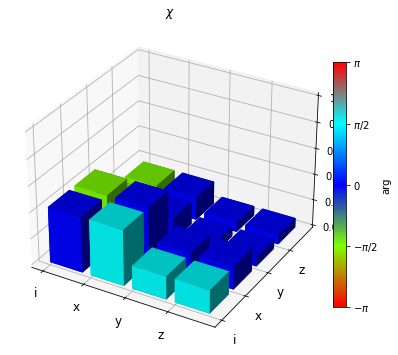

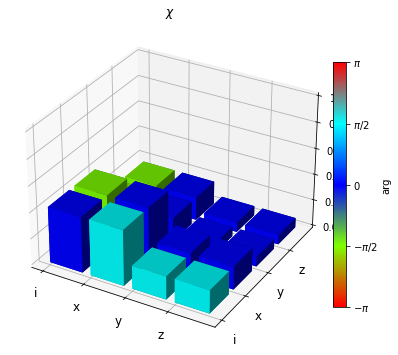